In [1]:
import pickle

import matplotlib
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBRFRegressor,train

matplotlib.use("Agg")
import matplotlib.pyplot as plt
from ase.db import connect




In [2]:
# load data from ase db
def load_data(ase_db_path,target = 'S1_exc'):
    db = connect(ase_db_path)
    print("Number of rows in the database: ", db.count())
    # Load representations, labels and values
    x_pool = []
    y_pool = []
    
    for db_row in db.select():
        x_pool.append(db_row.data['slatm'])
        y_pool.append(db_row.data[target])
    x_pool = np.array(x_pool)
    y_pool = np.array(y_pool)
    return x_pool, y_pool
def fws_scaling(x_pool):
    left_shape = x_pool.shape[1] - 13 -4368
    ic = []
    one_b = list(range(0, 13))
    ic.append(one_b)
    two_b = list(range(13, 4368 + 13))
    ic.append(two_b)
    three_b = list(range(4368 + 13, left_shape + 4368 + 13))
    ic.append(three_b)

    fw_one_b = 1 / (3 * 13)
    fw_two_b = 1 / (3 * 4368)
    fw_three_b = 1 / (3 * left_shape)
    fws = np.zeros((x_pool.shape[1]))
    for i in range(x_pool.shape[1]):
        if i < 13:
            fws[i] = fw_one_b
        elif i < 4381:
            fws[i] = fw_two_b
        else:
            fws[i] = fw_three_b
    assert np.isclose(np.sum(fws), 1)
    return fws
def plot_learning_curves(results,target):
        # Plot learning curves
    plt.rc("font", size=22)
    plt.plot(results["validation_0"]["mae"], label="train")
    plt.plot(results["validation_1"]["mae"], label="test")
    plt.xlabel("Estimators")
    plt.ylabel(f"{target} MAE (eV)$")
    # Show the legend
    plt.legend()
    # Show and save the plot
    plt.show()
    plt.savefig("xgboost_S1_exc_lc.png")
def main(target):
    # Load data
    x_pool, y_pool = load_data("/media/mohammed/Work/FORMED_ML/ase_database/formed.db",target)
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        x_pool, y_pool, test_size=0.1, random_state=1
    )
    fws = fws_scaling(X_train)
    # Define the model
    model = XGBRegressor(
        n_estimators=5000,
        eta=0.05,
        colsample_bytree=0.75,
        max_depth=8,
        eval_metric="mae",
        early_stopping_rounds=10, 
        feature_weights=fws
    )    
    # Train the model
    model.fit(X_train, y_train)
    # Make predictions
    y_pred = model.predict(X_test)
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print("MAE: ", mae)
    print("R2: ", r2)
    # Save the model
    with open("model.pkl", "wb") as f:
        pickle.dump(model, f)
    
    # Retrieve performance metrics
    results = model.evals_result()

    # Plot learning curves
    plot_learning_curves(results,target)
    


#print("Shape of data: ", X_pool.shape, y_pool.shape)

Number of rows in the database:  116687


In [3]:

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    x_pool, y_pool, test_size=0.1, random_state=1
)

# 13 one body pot, 91 2 body pot and 1183 3 body pots.
# 2 body pots are 48 long, 3 body pots are 39 long
# for a total of 50518 SLATM terms
left_shape = 17941 - 13 -4368
ic = []
one_b = list(range(0, 13))
ic.append(one_b)
two_b = list(range(13, 4368 + 13))
ic.append(two_b)
three_b = list(range(4368 + 13, left_shape + 4368 + 13))
ic.append(three_b)

fw_one_b = 1 / (3 * 13)
fw_two_b = 1 / (3 * 4368)
fw_three_b = 1 / (3 * left_shape)
fws = np.zeros((17941))
for i in range(17941):
    if i < 13:
        fws[i] = fw_one_b
    elif i < 4381:
        fws[i] = fw_two_b
    else:
        fws[i] = fw_three_b
assert np.isclose(np.sum(fws), 1)

# Define the model
model = XGBRegressor(
    n_estimators=5000,
    eta=0.05,
    colsample_bytree=0.75,
    max_depth=8,
    eval_metric="mae",
    #early_stopping_rounds=10, 
    #feature_weights=fws
)
# Define the datasets to evaluate each iteration for early stopping
evalset = [(X_train, y_train), (X_test, y_test)]

# Fit the model
model.fit(
    X_train, y_train, eval_set=evalset
)
# Evaluate performance
y_hat = model.predict(X_test)
err = np.abs(y_hat - y_test)
print(
    f"Max error at id {np.where(y_pool == y_test[np.argmax(err)])} : {np.max(err)} out of reference {y_test[np.argmax(err)]}"
)
print(
    f"Min error at id {np.where(y_pool == y_test[np.argmin(err)])} : {np.min(err)} out of reference {y_test[np.argmin(err)]}"
)
print(f"std of errors is {np.std(err)}")
r2 = r2_score(y_test, y_hat)
mae = mean_absolute_error(y_test, y_hat)
print("r2: %.3f" % r2)
print("mae: %.3f" % mae)

# Retrieve performance metrics
results = model.evals_result()

# Plot learning curves
plt.rc("font", size=22)
plt.plot(results["validation_0"]["mae"], label="train")
plt.plot(results["validation_1"]["mae"], label="test")
plt.xlabel("Estimators")
plt.ylabel(r"$S_{1}^{vert}$ MAE $\it{(eV)}$")

# Show the legend
plt.legend()

# Show and save the plot
plt.show()
plt.savefig("xgboost_S1_exc_lc.png")
pickle.dump(model, open("S1_exc_model.sav", "wb"))

[0]	validation_0-mae:0.70130	validation_1-mae:0.70198
[1]	validation_0-mae:0.68364	validation_1-mae:0.68465
[2]	validation_0-mae:0.66774	validation_1-mae:0.66924
[3]	validation_0-mae:0.65104	validation_1-mae:0.65312
[4]	validation_0-mae:0.63572	validation_1-mae:0.63793
[5]	validation_0-mae:0.62107	validation_1-mae:0.62342
[6]	validation_0-mae:0.60667	validation_1-mae:0.60944
[7]	validation_0-mae:0.59304	validation_1-mae:0.59635
[8]	validation_0-mae:0.58057	validation_1-mae:0.58426
[9]	validation_0-mae:0.56899	validation_1-mae:0.57295
[10]	validation_0-mae:0.55719	validation_1-mae:0.56144
[11]	validation_0-mae:0.54613	validation_1-mae:0.55062
[12]	validation_0-mae:0.53641	validation_1-mae:0.54127
[13]	validation_0-mae:0.52721	validation_1-mae:0.53248
[14]	validation_0-mae:0.51750	validation_1-mae:0.52333
[15]	validation_0-mae:0.50802	validation_1-mae:0.51420
[16]	validation_0-mae:0.50003	validation_1-mae:0.50665
[17]	validation_0-mae:0.49193	validation_1-mae:0.49897
[18]	validation_0-ma

KeyboardInterrupt: 

In [6]:
results = model.evals_result()

plt.rc("font", size=22)
plt.plot(results["validation_0"]["mae"], label="train")
plt.plot(results["validation_1"]["mae"], label="test")
plt.xlabel("Estimators")
plt.ylabel(r"$S_{1}^{vert}$ MAE $\it{(eV)}$")

# Show the legend
plt.legend()

XGBoostError: No evaluation result, `eval_set` is not used during training.

/tmp/ipykernel_116265/71735940.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


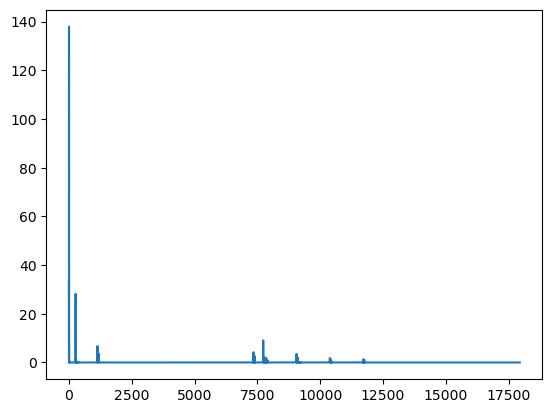

In [25]:
%matplotlib inline
fig, ax = plt.subplots()

ax.plot(X_test[10])
fig.show()

In [14]:
#load model
model = pickle.load(open("S1_exc_model.sav", "rb"))
# Predict
y_hat = model.predict(X_test)
# Evaluate performance
err = np.abs(y_hat - y_test)
print(
    f"Max error at id {np.where(y_pool == y_test[np.argmax(err)])} : {np.max(err)} out of reference {y_test[np.argmax(err)]}"
)

/media/mohammed/Work/anaconda3/envs/fair-chem/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:36:27] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)
/media/mohammed/Work/anaconda3/envs/fair-chem/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [10:36:27] WARNING: /workspace/src/learner.cc:872: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.
  warnings.warn(smsg, UserWarning)


ValueError: Feature shape mismatch, expected: 50518, got 17941

In [6]:
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.75, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.05, eval_metric='mae',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=5000,
             n_jobs=None, num_parallel_tree=None, ...)